In [301]:
## what effect does time have on district (and race or age)
## replace district w location

## is there a stronger correlation between incidents at night by race that spur requests vs incidents at night

In [302]:
import pandas as pd
from lib import standardize_item_numbers
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
import statsmodels.api as sm
from scipy import stats

In [303]:
def clean():
    dfa = pd.read_csv("../data/electronic_police_report_2018_2022.csv")
    dfa = dfa.pipe(standardize_item_numbers, ["item_number"])

    dfb = pd.read_csv("../data/rtcc.csv")
    dfb["rtcc_requested"] = "1"
    dfb = dfb.pipe(standardize_item_numbers, ["item_number"])

    df = pd.merge(dfa, dfb, on="item_number", how="outer")
    return df

In [304]:
df = clean()

C:\Users\PC\AppData\Local\Temp\ipykernel_11580\2311211475.py:2: DtypeWarning: Columns (14,20,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  dfa = pd.read_csv("../data/electronic_police_report_2018_2022.csv")


In [305]:
df.columns

Index(['Unnamed: 0', 'item_number', 'district', 'location', 'disposition',
       'signal_type', 'signal_description', 'occurred_date_time',
       'charge_code', 'charge_description', 'offender_race', 'offender_gender',
       'offender_age', 'offender_number', 'person_type', 'victim_race',
       'victim_gender', 'victim_age', 'victim_number', 'victim_fatal_status',
       'hate_crime', 'report_type', 'year', 'offenderid', 'offenderstatus',
       'persontype', 'Signal Code', 'rtcc_requested'],
      dtype='object')

In [306]:
df = df.drop_duplicates(subset=["offender_race", "offender_gender", "offender_age", "item_number"])

In [307]:
df['occurred_date_time'] = sorted(pd.to_datetime(df['occurred_date_time']))
df['hour'] = df['occurred_date_time'].dt.hour
df = df[~((df.hour.fillna("") == ""))]
df.loc[:, "hour"] = df.hour.astype(int)

In [308]:
# top_50_charge_descs_sr = (pd.Series(df.groupby("charge_description")
#                                                 .rtcc_requested.value_counts()
#                                                 .sort_values(ascending=False).head(10))
# )
# top_50_charge_descs_df = (pd.DataFrame(top_50_charge_descs_sr).unstack()
#                                                               .reset_index()
# )

# top_charge_desc_list = [x for x in top_50_charge_descs_df["charge_description"]]

In [309]:
# requested_df = df[((df.rtcc_requested == "1"))]
# not_requested_df = df[~((df.rtcc_requested == "1"))]

# requested_df = requested_df[requested_df.charge_description.isin(top_charge_desc_list)]
# not_requested_df = not_requested_df[not_requested_df.charge_description.isin(top_charge_desc_list)]

# requested_hours_ar = np.array(requested_df["hour"])
# not_requested_hours_ar = np.array(not_requested_df["hour"])

In [310]:
# requested_df.loc[:, "offender_race"] = (requested_df.offender_race.str.lower().str.strip().str.replace(r"unknown", "", regex=False)
#                                   .str.replace(r"^(?!(black)).*", "0", regex=True)
#                                   .str.replace(r"black", "1", regex=False)
# )

# requested_df[requested_df['offender_race'] == '1'].hour.plot(kind='hist', color='blue', edgecolor='black', alpha=0.5, figsize=(10, 7))
# requested_df[requested_df['offender_race'] == '0'].hour.plot(kind='hist', color='magenta', edgecolor='black', alpha=0.5, figsize=(10, 7))
# plt.legend(labels=['Blacks', 'Non-Blacks'])
# plt.title('Distribution of Surveillance Data Requests to RTCC', size=24)
# plt.xlabel('Hour of Day', size=18)
# plt.ylabel('Frequency', size=18)

In [311]:
# fig, ax = plt.subplots(figsize =(6,4) )
# ax.hist(requested_hours_ar, bins =20, color="k", edgecolor = 'black',  alpha=0.5)
# ax.set_title("NOPD Police Reports where RTCC data was requested by Time of Day")
# plt.show()

In [312]:
# fig, ax = plt.subplots(figsize =(6,4) )
# ax.hist(not_requested_hours_ar, bins =20, color="k", edgecolor = 'black',  alpha=0.5)
# ax.set_title("NOPD Police Reports where RTCC data was not requested by Time of Day")
# plt.show()

In [313]:
df.charge_description.value_counts().head(10)

THEFT                                    27869
SIMPLE BURGLARY                          24536
SIMPLE CRIMINAL DAMAGE TO PROPERTY       13749
THEFT OF A MOTOR VEHICLE                  8683
WARRANT ISSUED BY                         6749
DOMESTIC ABUSE BATTERY                    4510
BATTERY                                   4289
SIMPLE BATTERY                            3894
IDENTITY THEFT                            3435
POSSESSION OF MARIJUANA (1ST OFFENSE)     3034
Name: charge_description, dtype: int64

In [314]:
requested_df = df[((df.rtcc_requested == "1"))]
requested_df.offender_race.groupby(requested_df["rtcc_requested"]).describe()

,count,unique,top,freq
rtcc_requested,,,,
1,5768,6,BLACK,4251


In [317]:
not_requested_df = df[~((df.rtcc_requested == "1"))]
not_requested_df["rtcc_requested"] = "0"
not_requested_df.offender_race.groupby(not_requested_df["rtcc_requested"]).describe()

C:\Users\PC\AppData\Local\Temp\ipykernel_11580\3470198927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_requested_df["rtcc_requested"] = "0"


,count,unique,top,freq
rtcc_requested,,,,
0,140570,7,BLACK,91170


In [318]:
not_requested_df = not_requested_df.sample(frac=.5)

dfb = pd.concat([not_requested_df, requested_df])
dfb = dfb[~((dfb.rtcc_requested.fillna("") == ""))]
dfb.shape

(161549, 29)

In [319]:
# dfb = df[df.rtcc_requested == "1"]
dfb['sin_hour'] = np.sin(2 * np.pi * dfb['hour'] / max(dfb['hour'])) 
dfb['cos_hour'] = np.cos(2 * np.pi * dfb['hour'] / max(dfb['hour']))


dfb.loc[:, "rtcc_requested"] = dfb.rtcc_requested.astype(float)

dfb = dfb[~((dfb.offender_race.fillna("") == ""))]
dfb = dfb[~((dfb.rtcc_requested.fillna("") == ""))]
# dfb = dfb[~((dfb.sin_hour.fillna("") == ""))]
# dfb = dfb[~((dfb.cos_hour.fillna("") == ""))]
# dfb = dfb[~((dfb.disposition.fillna("") == ""))]
# dfb = dfb[~((dfb.offender_age.fillna("") == ""))]

In [320]:
# for col in df:
#     if not pd.api.types.is_numeric_dtype(df[col]):
#         df = pd.get_dummies(df, columns=[col], prefix=col, drop_first=True)


dispositions = pd.get_dummies(dfb["disposition"], drop_first=True)
dfb = pd.concat([dfb, dispositions], axis=1)

races = pd.get_dummies(dfb["offender_race"], drop_first=True)
dfb = pd.concat([dfb, races], axis=1)
charges = pd.get_dummies(dfb["charge_description"], drop_first=True)
dfb = pd.concat([dfb, charges], axis=1)

In [321]:
dfc = dfb[["rtcc_requested", "cos_hour", "sin_hour", "ASIAN","BLACK", "HISPANIC", "UNKNOWN", "WHITE", "THEFT", "SIMPLE BURGLARY", "SIMPLE CRIMINAL DAMAGE TO PROPERTY", "THEFT OF A MOTOR VEHICLE", "WARRANT ISSUED BY", "DOMESTIC ABUSE BATTERY", "BATTERY", "SIMPLE BATTERY", "IDENTITY THEFT", "POSSESSION OF MARIJUANA (1ST OFFENSE)"]]

In [322]:
corr_df = pd.DataFrame(columns=["r", "p"])
for col in dfc:
    if pd.api.types.is_numeric_dtype(dfc[col]):
        r, p = stats.pearsonr(dfb.rtcc_requested, dfc[col])
        corr_df.loc[col] = [round(r, 3), round(p, 3)]
corr_df

,r,p
rtcc_requested,1.000,0.000
cos_hour,0.003,0.424
sin_hour,0.004,0.222
ASIAN,-0.006,0.081
BLACK,0.050,0.000
HISPANIC,-0.002,0.517
UNKNOWN,-0.035,0.000
WHITE,-0.027,0.000
THEFT,-0.059,0.000
SIMPLE BURGLARY,-0.028,0.000


In [323]:
train, test = train_test_split(dfc, test_size=0.2)

x_test = np.array(test)
y_test = np.array(test.rtcc_requested)

x_train = np.array(train)
y_train = np.array(train.rtcc_requested)

In [324]:
model = sm.OLS(y_train, x_train)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.518e+33
Date:                Sat, 24 Dec 2022   Prob (F-statistic):                        0.00
Time:                        12:15:44   Log-Likelihood:                      2.0821e+06
No. Observations:               60779   AIC:                                 -4.164e+06
Df Residuals:                   60761   BIC:                                 -4.164e+06
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [325]:
lr = LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True,
    ).fit(x_train, y_train)


sgd = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        loss='log',
        class_weight='balanced'
    ).fit(x_train, y_train)


sgd_huber = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        alpha=20,
        loss='modified_huber',
        class_weight='balanced'
    ).fit(x_train, y_train)

y_pred_lr = lr.predict(x_test)
test["scores_lr"] = y_pred_lr
lrs = []
for score in test["scores_lr"]:
    lrs.append(f1_score(y_test, y_pred_lr, average="weighted"))

y_pred_sgd = sgd.predict(x_test)
test["scores_sgd"] = y_pred_sgd
sgds = []
for score in test["scores_sgd"]:
    sgds.append(f1_score(y_test, y_pred_sgd, average="weighted"))


y_pred_sgd_huber = sgd_huber.predict(x_test)
test["scores_sgd_huber"] = y_pred_sgd_huber
sgds_huber = []
for score in test["scores_sgd_huber"]:
    sgds_huber.append(f1_score(y_test, y_pred_sgd_huber, average="weighted"))


print(f'Logistic Regression Val f1: {np.mean(lrs):.3f} +- {np.std(lrs):.3f}')
print(f'Logistic Regression SGD f1: {np.mean(sgds):.3f} +- {np.std(sgds):.3f}')
print(f'SVM Huber Val f1: {np.mean(sgds_huber):.3f} +- {np.std(sgds_huber):.3f}')

C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


KeyboardInterrupt: 

Feature: 0, Score: 11.95197
Feature: 1, Score: 0.00876
Feature: 2, Score: 0.04297
Feature: 3, Score: -0.00424
Feature: 4, Score: 0.09989
Feature: 5, Score: 0.00735
Feature: 6, Score: -0.04587
Feature: 7, Score: -0.06254
Feature: 8, Score: -0.31551
Feature: 9, Score: -0.12719
Feature: 10, Score: -0.24963
Feature: 11, Score: 0.04438
Feature: 12, Score: -0.40051
Feature: 13, Score: -0.24721
Feature: 14, Score: -0.09850
Feature: 15, Score: 0.00979
Feature: 16, Score: -0.09553
Feature: 17, Score: -0.20185


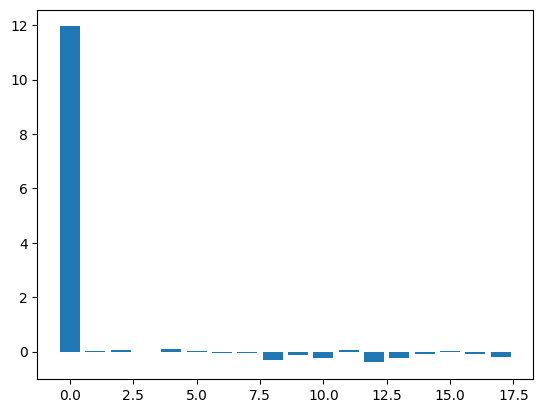

In [ ]:
log_feat_importance = lr.coef_[0]
# summarize feature importance
for i,v in enumerate(log_feat_importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(log_feat_importance))], log_feat_importance)
plt.show()

Feature: 0, Score: 12.00909
Feature: 1, Score: 0.01577
Feature: 2, Score: 0.03626
Feature: 3, Score: -0.00457
Feature: 4, Score: 0.11480
Feature: 5, Score: 0.01259
Feature: 6, Score: -0.04069
Feature: 7, Score: -0.05646
Feature: 8, Score: -0.31129
Feature: 9, Score: -0.12363
Feature: 10, Score: -0.24703
Feature: 11, Score: 0.04593
Feature: 12, Score: -0.39471
Feature: 13, Score: -0.24795
Feature: 14, Score: -0.10751
Feature: 15, Score: 0.01827
Feature: 16, Score: -0.09188
Feature: 17, Score: -0.19621


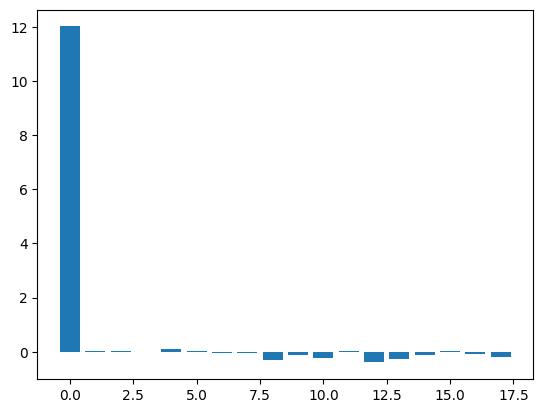

In [ ]:
log_feat_importance = sgd.coef_[0]
# summarize feature importance
for i,v in enumerate(log_feat_importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(log_feat_importance))], log_feat_importance)
plt.show()

r2 score:  1.0
Mean_sqrd_error:  8.290778248657988e-30
Root_mean_squared error:  2.8793711550715354e-15
Feature: 0, Score: 1.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: -0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: -0.00000
Feature: 17, Score: -0.00000


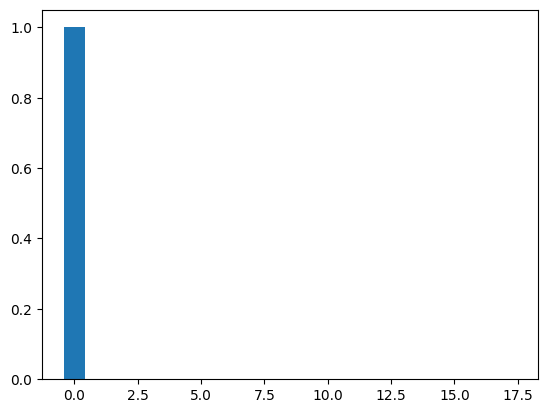

In [ ]:
LR = LinearRegression()

LR.fit(x_train,y_train)
y_prediction =  LR.predict(x_test)
score=r2_score(y_test,y_prediction)

print("r2 score: ", score)
print("Mean_sqrd_error: ", mean_squared_error(y_test,y_prediction))
print("Root_mean_squared error: ", np.sqrt(mean_squared_error(y_test,y_prediction)))

lr_feature_importance = LR.coef_

for i,v in enumerate(lr_feature_importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
 
plt.bar([x for x in range(len(lr_feature_importance))], lr_feature_importance)
plt.show()

Feature: 0, Score: 1.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000


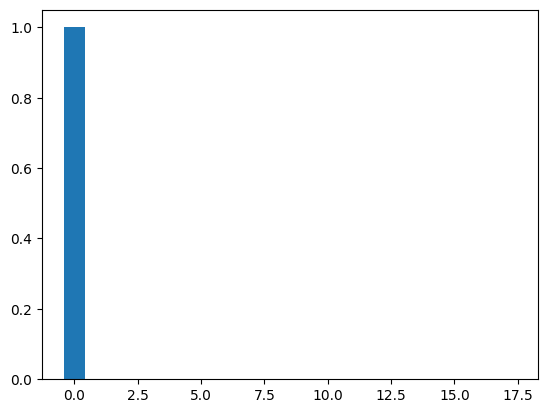

In [ ]:
dtr = DecisionTreeRegressor()

dtr.fit(x_train, y_train)

dtr_feat_importance = dtr.feature_importances_

for i,v in enumerate(dtr_feat_importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(dtr_feat_importance))], dtr_feat_importance)
plt.show()

Feature: 0, Score: 1.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000


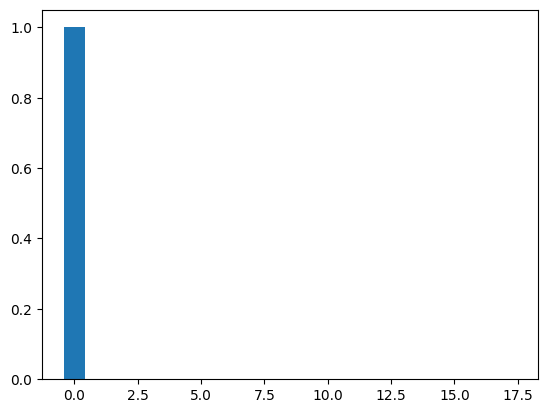

In [ ]:
dtc = DecisionTreeClassifier()

dtc.fit(x_train, y_train)

dtc_feat_importance = dtc.feature_importances_

for i,v in enumerate(dtc_feat_importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(dtc_feat_importance))], dtc_feat_importance)
plt.show()

Feature: 0, Score: 1.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000


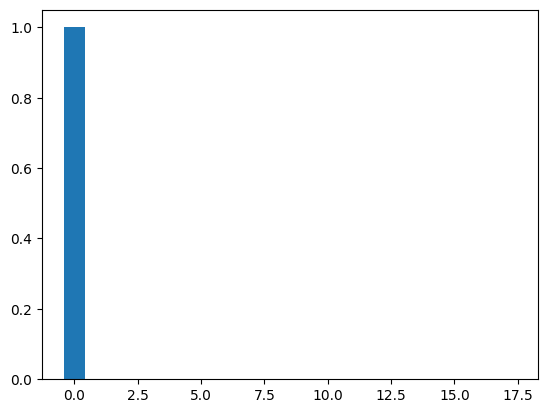

In [ ]:
rfr = RandomForestRegressor()

rfr.fit(x_train, y_train)

rfr_feat_importance = rfr.feature_importances_

for i,v in enumerate(rfr_feat_importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(rfr_feat_importance))], rfr_feat_importance)
plt.show()

Feature: 0, Score: 0.96220
Feature: 1, Score: 0.00160
Feature: 2, Score: 0.00214
Feature: 3, Score: 0.00003
Feature: 4, Score: 0.00207
Feature: 5, Score: 0.00019
Feature: 6, Score: 0.00140
Feature: 7, Score: 0.00058
Feature: 8, Score: 0.00592
Feature: 9, Score: 0.00134
Feature: 10, Score: 0.00329
Feature: 11, Score: 0.00036
Feature: 12, Score: 0.01023
Feature: 13, Score: 0.00461
Feature: 14, Score: 0.00060
Feature: 15, Score: 0.00013
Feature: 16, Score: 0.00077
Feature: 17, Score: 0.00253


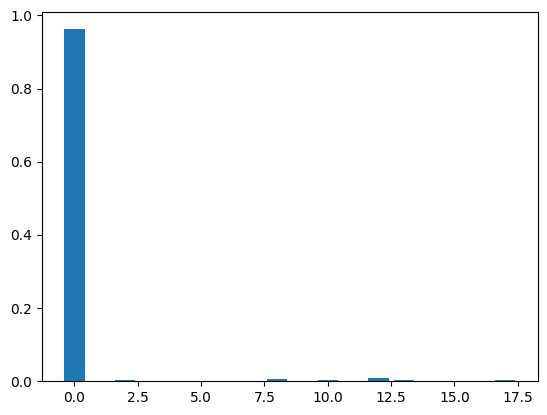

In [ ]:
rfc = RandomForestClassifier()

rfc.fit(x_train, y_train)

rfc_feat_importance = rfc.feature_importances_

for i,v in enumerate(rfc_feat_importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(rfc_feat_importance))], rfc_feat_importance)
plt.show()